# Performance Settings

Set `FAST_MODE = True` for faster inference on smaller GPUs (reduces quality but speeds up generation)

In [1]:
# Set to True for faster inference on smaller GPUs
FAST_MODE = False  # Change to True for faster generation with lower quality

# Fast mode settings
if FAST_MODE:
    FAST_NUM_DIFFUSION_STEPS = 5  # Reduced from 20 (much faster for testing)
    FAST_IMAGE_SIZE = 64  # Reduced from 128 (smaller images)
    FAST_NUM_SEEDS = 1  # Reduced to 1 for quickest testing
    FAST_MAX_ITER_TO_ALTER = 5  # Reduced iterations for Attend-and-Excite
else:
    FAST_NUM_DIFFUSION_STEPS = 50
    FAST_IMAGE_SIZE = 256
    FAST_NUM_SEEDS = None  # Use all provided seeds
    FAST_MAX_ITER_TO_ALTER = 25

In [2]:
from typing import List, Dict, Optional
import torch

import sys 
sys.path.append(".")
sys.path.append("..")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore

%load_ext autoreload 
%autoreload 2

# Load Model Weights (may take a few minutes)

In [3]:
NUM_DIFFUSION_STEPS = FAST_NUM_DIFFUSION_STEPS if FAST_MODE else 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")
# stable = AttendAndExcitePipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
# Not enough memory for full precision model
stable = AttendAndExcitePipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16).to(device)
tokenizer = stable.tokenizer

Using device: cuda:0


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


# Pipeline Wrapper

In [4]:
# configurable parameters (see RunConfig for all parameters)
# scale factor - intensity of shift by gradient
# thresholds - a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {0:0.05, 10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False,
                    sd_2_1: bool = False):
    # Use faster settings in fast mode
    if FAST_MODE:
        max_iter_to_alter = FAST_MAX_ITER_TO_ALTER
        thresholds = {0: 0.1}  # Simplified threshold for speed
    
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter,
                       sd_2_1=sd_2_1)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config)
    if display_output:
        display(image)
    return image

# Run Inference on a Set of Seeds and Generate an Image Grid

In [5]:
def get_indices_to_alter_auto(prompt: str, stable):
    """Automatically extract noun token indices without user input."""
    token_idx_to_word = {idx: stable.tokenizer.decode(t)
                         for idx, t in enumerate(stable.tokenizer(prompt)['input_ids'])
                         if 0 < idx < len(stable.tokenizer(prompt)['input_ids']) - 1}
    
    # Automatically select non-stopword tokens (nouns, verbs, adjectives)
    # Skip common words like 'a', 'and', 'the', 'of', 'in', etc.
    stopwords = {'a', 'an', 'and', 'the', 'of', 'in', 'on', 'at', 'to', 'for', 'with', 'by', 'from'}
    token_indices = [idx for idx, word in token_idx_to_word.items() if word.strip().lower() not in stopwords]
    
    print(f"Token mapping: {token_idx_to_word}")
    print(f"Auto-selected indices: {token_indices} -> {[token_idx_to_word[i] for i in token_indices]}")
    return token_indices

def generate_images_for_method(prompt: str,
                               seeds: List[int],
                               indices_to_alter: Optional[List[int]] = None,
                               is_attend_and_excite: bool = True,
                               sd_2_1: bool = False):
    # Use automatic token selection instead of interactive input
    token_indices = get_indices_to_alter_auto(prompt, stable) if indices_to_alter is None else indices_to_alter
    
    # Use fewer seeds in fast mode
    if FAST_MODE and FAST_NUM_SEEDS is not None:
        seeds = seeds[:FAST_NUM_SEEDS]
    
    images = []
    for seed in seeds:
        g = torch.Generator('cuda').manual_seed(seed)
        prompts = [prompt]
        controller = AttentionStore()
        run_standard_sd = False if is_attend_and_excite else True
        image = run_and_display(prompts=prompts,
                                controller=controller,
                                indices_to_alter=token_indices,
                                generator=g,
                                run_standard_sd=run_standard_sd,
                                sd_2_1=sd_2_1)
        # Use smaller image size in fast mode
        img_size = FAST_IMAGE_SIZE if FAST_MODE else 256
        images.append(image.resize((img_size, img_size)))
    grid = vis_utils.get_image_grid(images)
    display(grid)

# Stable Diffusion vs. Attend-and-Excite

## Stable Diffusion

Token mapping: {1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'frog'}
Auto-selected indices: [2, 5] -> ['cat', 'frog']


/gpfs/home2/sciarella/attend-and-excite/notebooks/../pipeline_attend_and_excite.py:489: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/50 [00:00<?, ?it/s]

/home/sciarella/attend-and-excite/venv/lib64/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:589: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

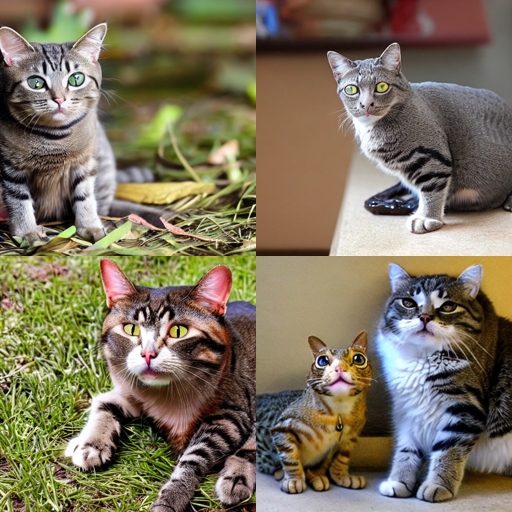

In [6]:
generate_images_for_method(
    prompt="a cat and a frog",
    seeds=[6141, 9031, 969, 1910],
    is_attend_and_excite=False
)

## Attend-and-Excite

Token mapping: {1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'frog'}
Auto-selected indices: [2, 5] -> ['cat', 'frog']


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0264
Iteration 1 | Loss: 0.0293
Iteration 2 | Loss: 0.0293
Iteration 3 | Loss: 0.0103
Iteration 4 | Loss: 0.0122
Iteration 5 | Loss: 0.0103
Iteration 6 | Loss: 0.0132
Iteration 7 | Loss: 0.0078
Iteration 8 | Loss: 0.0249
Iteration 9 | Loss: 0.0068
Iteration 10 | Loss: 0.0317
Iteration 11 | Loss: 0.0068
Iteration 12 | Loss: 0.0210
Iteration 13 | Loss: 0.0078
Iteration 14 | Loss: 0.0254
Iteration 15 | Loss: 0.0107
Iteration 16 | Loss: 0.0356
Iteration 17 | Loss: 0.0127
Iteration 18 | Loss: 0.0347
Iteration 19 | Loss: 0.0171
Iteration 20 | Loss: 0.0244
Iteration 21 | Loss: 0.0195
Iteration 22 | Loss: 0.0239
Iteration 23 | Loss: 0.0229
Iteration 24 | Loss: 0.0264


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0635
Iteration 1 | Loss: 0.0127
Iteration 2 | Loss: 0.0127
Iteration 3 | Loss: 0.0078
Iteration 4 | Loss: 0.0044
Iteration 5 | Loss: 0.0029
Iteration 6 | Loss: 0.0024
Iteration 7 | Loss: 0.0029
Iteration 8 | Loss: 0.0029
Iteration 9 | Loss: 0.0029
Iteration 10 | Loss: 0.0029
Iteration 11 | Loss: 0.0029
Iteration 12 | Loss: 0.0029
Iteration 13 | Loss: 0.0029
Iteration 14 | Loss: 0.0039
Iteration 15 | Loss: 0.0039
Iteration 16 | Loss: 0.0054
Iteration 17 | Loss: 0.0059
Iteration 18 | Loss: 0.0083
Iteration 19 | Loss: 0.0093
Iteration 20 | Loss: 0.0112
Iteration 21 | Loss: 0.0176
Iteration 22 | Loss: 0.0142
Iteration 23 | Loss: 0.0176
Iteration 24 | Loss: 0.0186


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.1631
Iteration 1 | Loss: 0.1030
Iteration 2 | Loss: 0.1221
Iteration 3 | Loss: 0.0244
Iteration 4 | Loss: 0.0073
Iteration 5 | Loss: 0.0049
Iteration 6 | Loss: 0.0039
Iteration 7 | Loss: 0.0029
Iteration 8 | Loss: 0.0039
Iteration 9 | Loss: 0.0044
Iteration 10 | Loss: 0.0049
Iteration 11 | Loss: 0.0073
Iteration 12 | Loss: 0.0068
Iteration 13 | Loss: 0.0098
Iteration 14 | Loss: 0.0078
Iteration 15 | Loss: 0.0112
Iteration 16 | Loss: 0.0112
Iteration 17 | Loss: 0.0137
Iteration 18 | Loss: 0.0142
Iteration 19 | Loss: 0.0156
Iteration 20 | Loss: 0.0166
Iteration 21 | Loss: 0.0176
Iteration 22 | Loss: 0.0195
Iteration 23 | Loss: 0.0210
Iteration 24 | Loss: 0.0225


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0825
Iteration 1 | Loss: 0.0093
Iteration 2 | Loss: 0.0088
Iteration 3 | Loss: 0.0063
Iteration 4 | Loss: 0.0049
Iteration 5 | Loss: 0.0054
Iteration 6 | Loss: 0.0049
Iteration 7 | Loss: 0.0229
Iteration 8 | Loss: 0.0059
Iteration 9 | Loss: 0.0078
Iteration 10 | Loss: 0.0078
Iteration 11 | Loss: 0.0093
Iteration 12 | Loss: 0.0103
Iteration 13 | Loss: 0.0112
Iteration 14 | Loss: 0.0112
Iteration 15 | Loss: 0.0151
Iteration 16 | Loss: 0.0127
Iteration 17 | Loss: 0.0166
Iteration 18 | Loss: 0.0146
Iteration 19 | Loss: 0.0161
Iteration 20 | Loss: 0.0166
Iteration 21 | Loss: 0.0176
Iteration 22 | Loss: 0.0195
Iteration 23 | Loss: 0.0200
Iteration 24 | Loss: 0.0234


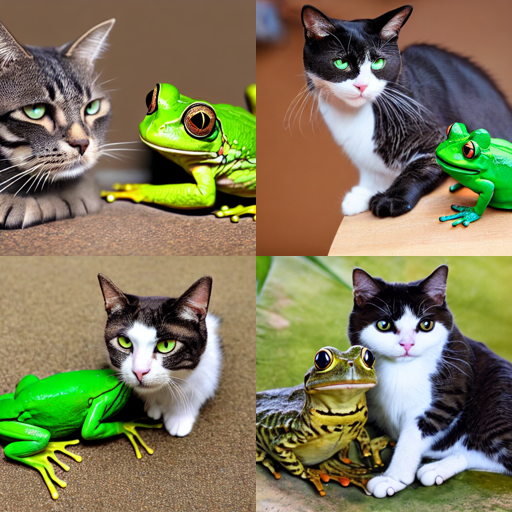

In [7]:
generate_images_for_method(
    prompt="a cat and a frog",
    seeds=[6141, 9031, 969, 1910],
    is_attend_and_excite=True
)

## Stable Diffusion

Token mapping: {1: 'a', 2: 'mouse', 3: 'and', 4: 'a', 5: 'red', 6: 'car'}
Auto-selected indices: [2, 5, 6] -> ['mouse', 'red', 'car']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

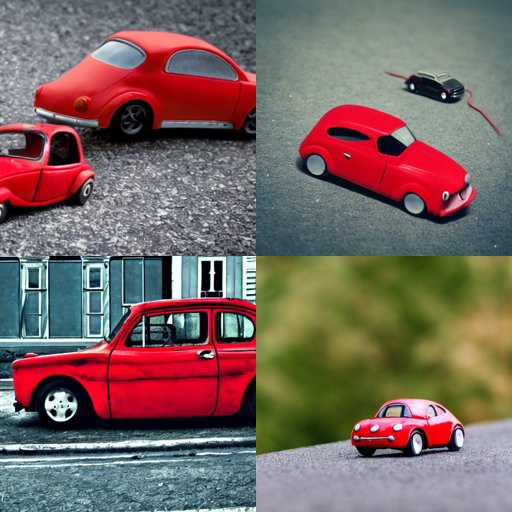

In [8]:
generate_images_for_method(
    prompt="a mouse and a red car",
    seeds=[7803, 2098, 15792, 2354],
    is_attend_and_excite=False
)

## Attend-and-Excite

Token mapping: {1: 'a', 2: 'mouse', 3: 'and', 4: 'a', 5: 'red', 6: 'car'}
Auto-selected indices: [2, 5, 6] -> ['mouse', 'red', 'car']


  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. red has a max attention of 0.01287841796875
	 Try 2. red has a max attention of 0.0128936767578125
	 Try 3. red has a max attention of 0.012908935546875
	 Try 4. red has a max attention of 0.0129241943359375
	 Try 5. red has a max attention of 0.01294708251953125
	 Try 6. red has a max attention of 0.0129547119140625
	 Try 7. red has a max attention of 0.01297760009765625
	 Try 8. red has a max attention of 0.01299285888671875
	 Try 9. red has a max attention of 0.01300811767578125
	 Try 10. red has a max attention of 0.01302337646484375
	 Try 11. red has a max attention of 0.0130462646484375
	 Try 12. red has a max attention of 0.0130615234375
	 Try 13. red has a max attention of 0.0130767822265625
	 Try 14. red has a max attention of 0.013092041015625
	 Try 15. red has a max attention of 0.0131072998046875
	 Try 16. red has a max attention of 0.01312255859375
	 Try 17. red has a max attention of 0.01314544677734375
	 Try 18. red has a max attention of 0.01316070556640625
	 T

  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. red has a max attention of 0.01259613037109375
	 Try 2. red has a max attention of 0.01261138916015625
	 Try 3. red has a max attention of 0.01262664794921875
	 Try 4. red has a max attention of 0.01263427734375
	 Try 5. red has a max attention of 0.01265716552734375
	 Try 6. red has a max attention of 0.012664794921875
	 Try 7. red has a max attention of 0.0126800537109375
	 Try 8. red has a max attention of 0.0126953125
	 Try 9. red has a max attention of 0.0127105712890625
	 Try 10. red has a max attention of 0.01271820068359375
	 Try 11. red has a max attention of 0.01273345947265625
	 Try 12. red has a max attention of 0.01274871826171875
	 Try 13. red has a max attention of 0.01276397705078125
	 Try 14. red has a max attention of 0.01276397705078125
	 Try 15. red has a max attention of 0.012786865234375
	 Try 16. red has a max attention of 0.0128021240234375
	 Try 17. red has a max attention of 0.0128173828125
	 Try 18. red has a max attention of 0.01282501220703125
	 Tr

  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. red has a max attention of 0.01287841796875
	 Try 2. red has a max attention of 0.0129241943359375
	 Try 3. red has a max attention of 0.01306915283203125
	 Try 4. red has a max attention of 0.0131988525390625
	 Try 5. red has a max attention of 0.0133209228515625
	 Try 6. red has a max attention of 0.01342010498046875
	 Try 7. red has a max attention of 0.013519287109375
	 Try 8. red has a max attention of 0.01361083984375
	 Try 9. red has a max attention of 0.013702392578125
	 Try 10. red has a max attention of 0.01378631591796875
	 Try 11. red has a max attention of 0.01387786865234375
	 Try 12. red has a max attention of 0.0139617919921875
	 Try 13. red has a max attention of 0.0140380859375
	 Try 14. red has a max attention of 0.014129638671875
	 Try 15. red has a max attention of 0.01421356201171875
	 Try 16. red has a max attention of 0.0142974853515625
	 Try 17. red has a max attention of 0.01438140869140625
	 Try 18. red has a max attention of 0.01446533203125
	 Try 1

  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. red has a max attention of 0.01519775390625
	 Try 2. red has a max attention of 0.01526641845703125
	 Try 3. red has a max attention of 0.01534271240234375
	 Try 4. red has a max attention of 0.01541900634765625
	 Try 5. red has a max attention of 0.0155029296875
	 Try 6. red has a max attention of 0.0155792236328125
	 Try 7. red has a max attention of 0.015655517578125
	 Try 8. red has a max attention of 0.0157318115234375
	 Try 9. red has a max attention of 0.0158233642578125
	 Try 10. red has a max attention of 0.0159149169921875
	 Try 11. red has a max attention of 0.0160064697265625
	 Try 12. red has a max attention of 0.01611328125
	 Try 13. red has a max attention of 0.016204833984375
	 Try 14. red has a max attention of 0.0163116455078125
	 Try 15. red has a max attention of 0.0164031982421875
	 Try 16. red has a max attention of 0.016510009765625
	 Try 17. red has a max attention of 0.0166168212890625
	 Try 18. red has a max attention of 0.0167388916015625
	 Try 19. r

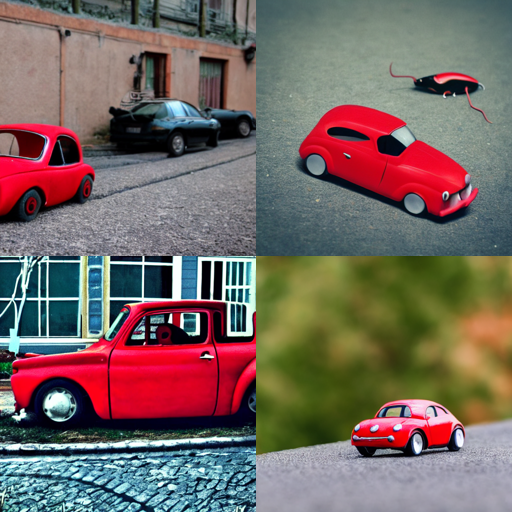

In [9]:
generate_images_for_method(
    prompt="a mouse and a red car",
    seeds=[7803, 2098, 15792, 2354],
    is_attend_and_excite=True
)

# Stable Diffusion 3.5

In [10]:
NUM_DIFFUSION_STEPS = FAST_NUM_DIFFUSION_STEPS if FAST_MODE else 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

import os

from diffusers import AutoPipelineForText2Image
from huggingface_hub import HfFolder

MODEL_ID = "stabilityai/stable-diffusion-3.5-medium"

# Token sources (safe for public repos):
# 1) Environment variables (set before starting the kernel), or
# 2) Hugging Face local cache (~/.cache/huggingface/token)
HF_TOKEN = (
    os.environ.get("HF_TOKEN")
    or os.environ.get("HUGGINGFACE_HUB_TOKEN")
    or os.environ.get("HUGGINGFACE_TOKEN")
    or os.environ.get("HF_API_TOKEN")
    or HfFolder.get_token()
)

if HF_TOKEN is None:
    raise RuntimeError(
        f"To download {MODEL_ID}, you must authenticate with Hugging Face.\n\n"
        "1) Open the model page and click 'Agree and access' to accept the terms.\n"
        "2) Then authenticate WITHOUT committing secrets:\n"
        "   - Recommended: run a one-time Python login in this environment:\n"
        "       from huggingface_hub import HfFolder; HfFolder.save_token('hf_...')\n"
        "     (stores the token in your user cache, not in this repo)\n"
        "   - Or set an env var BEFORE starting the notebook kernel:\n"
        "       export HF_TOKEN=hf_...\n\n"
        "After that, restart the notebook kernel and re-run this cell."
    )

dtype = torch.float16 if torch.cuda.is_available() else torch.float32

try:
    sd35 = AutoPipelineForText2Image.from_pretrained(MODEL_ID, torch_dtype=dtype, token=HF_TOKEN)
except Exception as e:
    msg = str(e)
    is_unauthorized = "401" in msg or "Unauthorized" in msg or "Invalid username or password" in msg
    if is_unauthorized:
        raise RuntimeError(
            f"Access denied for {MODEL_ID}. Make sure you accepted the model terms on Hugging Face "
            "and that your token is valid."
        ) from e
    raise

sd35 = sd35.to(device)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

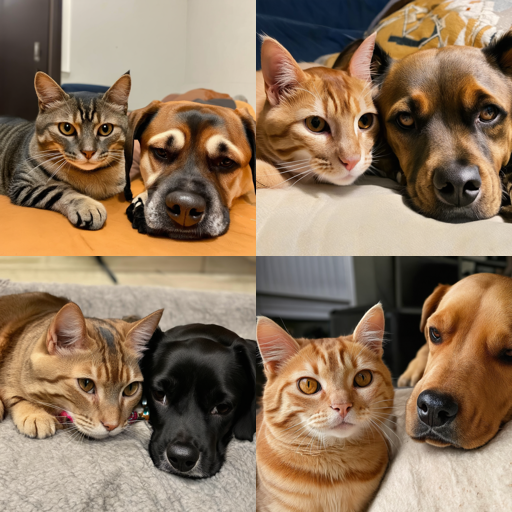

In [11]:
def generate_images_sd35(prompt: str, seeds: List[int]):
    # Use fewer seeds in fast mode
    if FAST_MODE and FAST_NUM_SEEDS is not None:
        seeds = seeds[:FAST_NUM_SEEDS]

    images = []
    for seed in seeds:
        g = torch.Generator(device.type).manual_seed(seed)
        out = sd35(
            prompt=prompt,
            guidance_scale=GUIDANCE_SCALE,
            num_inference_steps=NUM_DIFFUSION_STEPS,
            generator=g,
        )
        image = out.images[0]
        img_size = FAST_IMAGE_SIZE if FAST_MODE else 256
        images.append(image.resize((img_size, img_size)))
    grid = vis_utils.get_image_grid(images)
    display(grid)

generate_images_sd35(
    prompt="a cat and a dog",
    seeds=[39, 63, 68, 62],
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

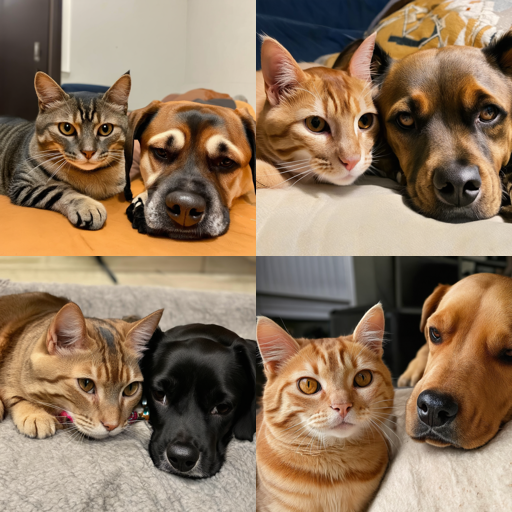

In [12]:
# Same call again (kept for parity with the previous section)
generate_images_sd35(
    prompt="a cat and a dog",
    seeds=[39, 63, 68, 62],
)